In [55]:
# Input data
import numpy as np
from utilities import *

# test and train read
Xtrain, Ytrain, list_ch_train = read_data(data_path="../../../datasets/har/har-data/", split="train")
Xtest, Ytest, list_ch_test = read_data(data_path="../../../datasets/har/har-data/", split="test")

print(list_ch_test, list_ch_train)
assert list_ch_train == list_ch_test, "Mistmatch in channels!"
assert Ytrain.max(axis=0) == Ytest.max(axis=0)
print(Ytrain.max(axis=0), Ytest.max(axis=0))

print(np.mean(Ytrain==0), np.mean(Ytrain==1), np.mean(Ytrain==2), np.mean(Ytrain==3), np.mean(Ytrain==4), 
      np.mean(Ytrain==5), np.mean(Ytrain==6), np.mean(Ytrain==7))

# Normalizing/standardizing the input data features
Xtrain, Xtest = standardize(test=Xtest, train=Xtrain)

# Onehot encoding of the output labels
print(Ytrain.shape, Ytest.shape)
Ytrain = one_hot(labels=Ytrain.reshape(-1), n_class=6) 
Ytest = one_hot(labels=Ytest.reshape(-1), n_class=6)
print(Ytrain.shape, Ytest.shape)

# Train and valid split
from sklearn.model_selection import train_test_split

# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Ytrain.shape, Yvalid.shape)

['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z'] ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']
6 6
0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352,) (2947,)
(7352, 6) (2947, 6)
(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [56]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [57]:
# Input data which is divided into train, valid, and testing.
N, W, Cin = Xvalid.shape[0], Xtrain.shape[1], Xtrain.shape[2]
X = tf.placeholder(dtype=tf.float32, name=None, shape=[N, W, Cin])
print(X.shape, X.dtype)

# Output data/labels
# assert Ytrain.max(axis=0)==Ytest.max(axis=0)
# Cout = Ytrain.max(axis=0)
# n_class=6
Cout = 6
Y = tf.placeholder(dtype=tf.float32, name=None, shape=[N, Cout])
print(Y.shape, Y.dtype)

(2206, 128, 9) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [58]:
# One convolution layer
print(X.shape, X.dtype)
Wwidth, Wchannels, Wnumber = X.shape[1].value//2, X.shape[2].value, X.shape[2].value*2
shape = [Wwidth, Wchannels, Wnumber]
initial_value = tf.random_normal(dtype=X.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
Wconv = tf.Variable(dtype=X.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=X)
Xconv = tf.maximum(name=None, x=(-0.1*Xconv), y=Xconv)
print(Xconv.shape, Xconv.dtype)

(2206, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(2206, 64, 18) <dtype: 'float32'>


In [59]:
# Multiplication layer
# shape = [-1, Xconv.shape[1].value*Xconv.shape[2].value] # N is None which is a value or creating an extra index
shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
Wchannels, Wnumber = Xconv_reshaped.shape[1].value, Y.shape[1].value
shape = [Wchannels, Wnumber]
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
logits = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(logits.shape, logits.dtype)
print(Y.shape, Y.dtype)

(2206, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(2206, 6) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [60]:
# Backward pass: error backpropagation
# Cost function
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y, name=None)
print(loss_tensor.shape, loss_tensor.dtype)
loss = tf.reduce_mean(axis=0, input_tensor=loss_tensor)
print(loss.shape, loss.dtype)

(2206,) <dtype: 'float32'>
() <dtype: 'float32'>


In [61]:
# Optimizer
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )
# minimize(
#     loss,
#     global_step=None,
#     var_list=None,
#     gate_gradients=GATE_OP,
#     aggregation_method=None,
#     colocate_gradients_with_ops=False,
#     name=None,
#     grad_loss=None
# )
optimizer = tf.train.AdamOptimizer().minimize(loss=loss)
print('optimizer', optimizer)
# adam = tf.train.AdamOptimizer
# print(adam)
# optimizer = adam.minimize(loss=loss)

optimizer name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_Variable_2/ApplyAdam"
input: "^Adam_1/update_Variable_3/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"



In [62]:
print(logits.shape, logits.dtype)
# Accuracy
# tf.argmax(
#     input,
#     axis=None,
#     name=None,
#     dimension=None,
#     output_type=tf.int64
# )
Ypred = tf.argmax(axis=1, name=None, input=logits, output_type=tf.int32)
# # tf.max is finding the max value among all the arguments and indices
# # tf.argmax is finding the arg/index with the max value
# Ylabel = tf.argmax()
print(Ypred.shape, Ypred.dtype)

# tf.nn.softmax(
#     logits,
#     axis=None,
#     name=None,
#     dim=None
# )
# softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis)
prob = tf.nn.softmax(axis=1, logits=logits, name=None)
print(prob.shape, prob.dtype)
Ypred2 = tf.argmax(axis=1, input=prob, name=None, output_type=tf.int32) 
print(Ypred2.shape, Ypred2.dtype)

print(Y.shape, Y.dtype)
Yref = tf.argmax(axis=1, input=Y, name=None, output_type=tf.int32)
print(Yref.shape, Yref.dtype)

(2206, 6) <dtype: 'float32'>
(2206,) <dtype: 'int32'>
(2206, 6) <dtype: 'float32'>
(2206,) <dtype: 'int32'>
(2206, 6) <dtype: 'float32'>
(2206,) <dtype: 'int32'>


In [63]:
acc_tensor = tf.equal(name=None, x=Ypred, y=Yref)
print(acc_tensor.shape, acc_tensor.dtype)
# cast bool to int datatype for equal
acc_tensor = tf.cast(dtype=tf.float16, name=None, x=acc_tensor)
print(acc_tensor.shape, acc_tensor.dtype)
acc = tf.reduce_mean(axis=0, input_tensor=acc_tensor)
print(acc.shape, acc.dtype)

(2206,) <dtype: 'bool'>
(2206,) <dtype: 'float16'>
() <dtype: 'float16'>


In [64]:
acc_tensor = tf.equal(name=None, x=Ypred2, y=Yref)
print(acc_tensor.shape, acc_tensor.dtype)
# cast bool to int datatype for equal
acc_tensor = tf.cast(dtype=tf.float16, name=None, x=acc_tensor)
print(acc_tensor.shape, acc_tensor.dtype)
acc2 = tf.reduce_mean(axis=0, input_tensor=acc_tensor)
print(acc2.shape, acc2.dtype)

(2206,) <dtype: 'bool'>
(2206,) <dtype: 'float16'>
() <dtype: 'float16'>


In [65]:
# correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
# print('correct_pred, accuracy', correct_pred, accuracy)

# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

In [66]:
# Minibatching techniques for online learning and offline learning of big dataset
# for X, Y in get_batches(X=X_train_norm, batch_size=N, y=Y_train_onehot):
#     print(X.shape, X.dtype, Y.shape, Y.dtype)

In [49]:
# Plotting the learning/loss curve
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
train_acc2, valid_acc2 = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    epochs=100
    for epoch in range(0, epochs, 1): # start=0, stop=epochs, step=1
        
        # Training
        loss_batch = []
        acc_batch, acc2_batch = [], []
        for Xarr, Yarr in get_batches(X=Xtrain, batch_size=N, y=Ytrain):

            # feeding the input array into TF framework and fetche the output
            feed_dict = {X:Xarr, Y:Yarr}
            lossarr, _, accarr, acc2arr = sess.run(feed_dict=feed_dict, fetches=[loss, optimizer, acc, acc2])
            loss_batch.append(np.mean(lossarr))
            acc_batch.append(np.mean(accarr))
            acc2_batch.append(np.mean(acc2arr))
        
        # Averaging the loss of the batch/minibatch
        train_loss.append(np.mean(loss_batch))
        train_acc.append(np.mean(acc_batch))
        train_acc2.append(np.mean(acc2_batch))
        
        # validation
        feed_dict = {X:Xvalid, Y:Yvalid}
        lossarr, accarr, acc2arr = sess.run(feed_dict=feed_dict, fetches=[loss, acc, acc2])
        valid_loss.append(np.mean(lossarr))
        valid_acc.append(np.mean(accarr))
        valid_acc2.append(np.mean(acc2arr))

        # Printing out the training and validating loss
        print('epoch:', epoch, 'training loss:', train_loss[epoch], 'validation loss:', valid_loss[epoch], 
              'training accuracy:', train_acc[epoch], 'validation accuracy:', valid_acc[epoch])
            
    saver.save(save_path='checkpoints/model.ckpt', sess=sess)

epoch: 0 training loss: 847.8561 validation loss: 857.9289 training accuracy: 0.04578 validation accuracy: 0.04352
epoch: 1 training loss: 804.94214 validation loss: 815.03656 training accuracy: 0.0553 validation accuracy: 0.04715
epoch: 2 training loss: 763.3336 validation loss: 773.2393 training accuracy: 0.0646 validation accuracy: 0.0562
epoch: 3 training loss: 723.04346 validation loss: 732.77606 training accuracy: 0.07544 validation accuracy: 0.068
epoch: 4 training loss: 684.34985 validation loss: 693.8594 training accuracy: 0.08496 validation accuracy: 0.0807
epoch: 5 training loss: 647.3578 validation loss: 656.5323 training accuracy: 0.1 validation accuracy: 0.09155
epoch: 6 training loss: 611.96155 validation loss: 620.6414 training accuracy: 0.1113 validation accuracy: 0.0988
epoch: 7 training loss: 577.9887 validation loss: 585.9383 training accuracy: 0.11896 validation accuracy: 0.10876
epoch: 8 training loss: 545.193 validation loss: 552.41815 training accuracy: 0.1278 v

epoch: 74 training loss: 87.249985 validation loss: 112.60657 training accuracy: 0.6553 validation accuracy: 0.6157
epoch: 75 training loss: 85.85715 validation loss: 111.33482 training accuracy: 0.66 validation accuracy: 0.6196
epoch: 76 training loss: 84.486565 validation loss: 110.07998 training accuracy: 0.662 validation accuracy: 0.6226
epoch: 77 training loss: 83.14101 validation loss: 108.842094 training accuracy: 0.666 validation accuracy: 0.6255
epoch: 78 training loss: 81.81805 validation loss: 107.62314 training accuracy: 0.6694 validation accuracy: 0.629
epoch: 79 training loss: 80.51817 validation loss: 106.42014 training accuracy: 0.671 validation accuracy: 0.63
epoch: 80 training loss: 79.243546 validation loss: 105.23201 training accuracy: 0.675 validation accuracy: 0.631
epoch: 81 training loss: 77.992874 validation loss: 104.06494 training accuracy: 0.6777 validation accuracy: 0.634
epoch: 82 training loss: 76.77136 validation loss: 102.92587 training accuracy: 0.6807

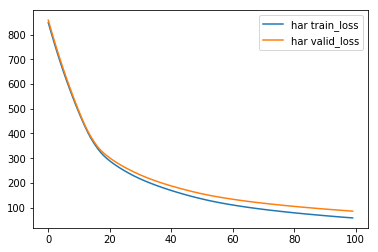

In [50]:
import matplotlib.pyplot as mplot
# % %matplotlib inline
# this is keeping the mpl inline or outline
# inline would inside this block and outline/out of block would be out of this block.
# %matplotlib inline
# %matplotlib
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [51]:
# Testing and playing around with checkpoints and trained model saved or saved trained model
# loaded_ckpt = tf.train.load_checkpoint(ckpt_dir_or_file='checkpoints/cnn-har.ckpt')
# loaded_ckpt.debug_string, 
# loaded_ckpt.get_variable_to_dtype_map()
# loaded_ckpt.get_variable_to_shape_map()

In [54]:
with tf.Session() as sess:
    # Restore the validated model
    save_path = tf.train.latest_checkpoint(checkpoint_dir='checkpoints/')
    saver.restore(save_path=save_path, sess=sess)
    
    loss_batch = []
    acc_batch, acc2_batch = [], []
    for Xarr, Yarr in get_batches(X=Xtest, batch_size=N, y=Ytest):
        feed_dict = {X:Xarr, Y:Yarr}
        lossarr, accarr, acc2arr = sess.run(feed_dict=feed_dict, fetches=[loss, acc, acc2])
        loss_batch.append(np.mean(lossarr))
        acc_batch.append(np.mean(accarr))
        acc2_batch.append(np.mean(acc2arr))

    # Print info for every iter/epoch
    print('test loss:', np.mean(loss_batch), 'test accuracy:', np.mean(acc_batch), np.mean(acc2_batch))

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
test loss: 107.731285 test accuracy: 0.5835 0.5835


In [ ]:
# print('some variable {what type inside and how many digits}/{what s inside and how manu digits}'.format())